In [2]:
import mxnet as mx
import numpy as np
import scipy as sp
import sys
import networkx as nx
import igraph as ig
import logging
import time
import matplotlib.pyplot as plt
import math

In [3]:
def get_act(act):
    if (act == 'sigmoid'):
        return sp.special.expit
    elif (act == 'tanh'):
        return np.tanh
    elif (act == 'relu'):
        return lambda x: np.maximum(x, 0)
    else:
        return None
    
weight_names = ['fc1_weight', 'fc2_weight']
bias_names = ['fc1_bias', 'fc2_bias']

def log_loss(x, y):
    return -(y * np.log(x) + (1 - y) * np.log(1 - x))

def logistic_np(x, y):
    return np.sum(log_loss(sp.special.expit(x), y))

def logistic_mx(x, y):
    x = 1/(1+mx.symbol.exp(-x))
    return mx.symbol.sum(-(y * mx.symbol.log(x) + (1 - y) * mx.symbol.log(1 - x)))

def get_loss(name):
    if (name == "L2"):
        l2_numpy = lambda x, y: np.sum(np.square(x - y))
        l2_mx = lambda x, y: mx.symbol.LinearRegressionOutput(data=x, label=y)
        return l2_numpy, l2_mx
    elif (name == "logistic"):
        sm_numpy = logistic_np
        sm_mx = logistic_mx
        return sm_numpy, sm_mx
    else:
        return None

def plot_errors(x, y):
    plt.plot(x, y)
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.show()

class AutoEncoderModel:
    def __init__(self, data, num_dims, internal_act=None, learning_rate=0.005, batch_size=50, loss_name="L2"):
        dims = [data.shape[1], num_dims, data.shape[1]]
        self.data = mx.symbol.Variable('data')
        self.y = mx.symbol.Variable('label')
        self.fc1_weight = mx.symbol.Variable(weight_names[0])
        self.fc1_bias = mx.symbol.Variable(bias_names[0])
        self.fc2_weight = mx.symbol.Variable(weight_names[1])
        self.fc2_bias = mx.symbol.Variable(bias_names[1])
        x = mx.symbol.FullyConnected(data=self.data, weight=self.fc1_weight,
                                     bias=self.fc1_bias, num_hidden=dims[1])
        if (internal_act is not None):
            x = mx.symbol.Activation(data=x, act_type=internal_act)
            print("Internal activation: " + internal_act)
        self.layer1 = x
        x = mx.symbol.FullyConnected(data=x, weight=self.fc2_weight,
                                     bias=self.fc2_bias, num_hidden=dims[2])
        self.layer2 = x
        print("loss func: " + loss_name)
        np_loss, mx_loss = get_loss(loss_name)
        # TODO How about using L1/L2 regularization.
        self.loss = mx_loss(x, self.y)
        self.model = mx.mod.Module(symbol=self.loss, data_names=['data'], label_names = ['label'])
        self.init_data(data, batch_size, learning_rate)
        
        def cal_model_numpy(params):
            fc1_weight = params.get(weight_names[0]).asnumpy()
            fc1_bias = params.get(bias_names[0]).asnumpy()
            fc2_weight = params.get(weight_names[1]).asnumpy()
            fc2_bias = params.get(bias_names[1]).asnumpy()

            np_data = data.asnumpy()
            hidden = np.dot(np_data, fc1_weight.T) + fc1_bias
            act_func = get_act(internal_act)
            if (act_func is not None):
                hidden = act_func(hidden)
            output = np.dot(hidden, fc2_weight.T) + fc2_bias
            return np_loss(output, np_data)

        self.numpy_cal = cal_model_numpy
        
    def init_data(self, data, batch_size=50, learning_rate=0.005):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        data_iter = mx.io.NDArrayIter(data={'data':data}, label={'label':data},
                batch_size=batch_size, shuffle=True,
                last_batch_handle='roll_over')
        print("Learning rate: " + str(learning_rate))
        print("batch size: " + str(batch_size))
        # allocate memory given the input data and label shapes
        self.model.bind(data_shapes=data_iter.provide_data, label_shapes=data_iter.provide_label)
        # initialize parameters by uniform random numbers
        self.model.init_params(initializer=mx.init.Uniform(scale=.1))
        # use SGD with learning rate 0.1 to train
        self.model.init_optimizer(optimizer='sgd',
                                  optimizer_params={'learning_rate': learning_rate,
                                                    'momentum': 0.9})

    def fit_int(self, data, batch_size, num_epoch, params=None, learning_rate=0.005, reinit_opt=True):
        data_iter = mx.io.NDArrayIter(data={'data':data}, label={'label':data},
                batch_size=batch_size, shuffle=True,
                last_batch_handle='roll_over')
        
        if (params is not None):
            self.model.set_params(arg_params=params, aux_params=None, force_init=True)
            if (reinit_opt):
                print("reinit optimizer. New learning rate: " + str(learning_rate))
                self.model.init_optimizer(optimizer='sgd',
                                          optimizer_params={'learning_rate': learning_rate,
                                                            'momentum': 0.9}, force_init=True)
        # use accuracy as the metric
        metric = mx.metric.create('acc')
        # train 5 epochs, i.e. going over the data iter one pass
        for epoch in range(num_epoch):
            data_iter.reset()
            metric.reset()
            for batch in data_iter:
                self.model.forward(batch, is_train=True)       # compute predictions
                self.model.update_metric(metric, batch.label)  # accumulate prediction accuracy
                self.model.backward()                          # compute gradients
                self.model.update()                            # update parameters
            #print('Epoch %d, Training %s' % (epoch, metric.get()))

    def train(self, data, num_epoc, params = None, debug=False, return_err=False, int_epoc=100):
        print("internal #epochs: " + str(num_epoc))
        prev_val = None
        reinit_opt = True
        plot_xs = []
        plot_yx = []
        start = time.time()
        for i in range(num_epoc/int_epoc):
            curr = time.time()
            self.fit_int(data, self.batch_size, int_epoc, params, self.learning_rate, reinit_opt=reinit_opt)
            if (debug):
                print(str(int_epoc) + " epochs takes " + str(time.time() - curr) + " seconds")
            reinit_opt = False

            params = self.model.get_params()[0]
            val = self.numpy_cal(params)
            plot_xs.append((i + 1) * int_epoc)
            plot_yx.append(val)
            if (debug):
                print("epoc " + str((i + 1) * int_epoc) + ": " + str(val))
                sys.stdout.flush()
            if (prev_val is not None and prev_val < val):
                self.learning_rate = self.learning_rate / 2
                reinit_opt = True
            prev_val = val
        print("It takes " + str(time.time() - start) + " seconds")
        print("The error: " + str(val))
        plot_errors(plot_xs, plot_yx)
        if (return_err):
            return params, plot_xs, plot_yx
        else:
            return params

In [4]:
def train(data, num_dims, num_epoc, internal_act=None, loss_name="L2", learning_rate=0.005, batch_size=50, debug=False, return_err=False):
    model = AutoEncoderModel(data, num_dims, internal_act, learning_rate, batch_size, loss_name)
    return model.train(data, num_epoc, debug=debug, return_err=return_err)

## Run on a low-rank data

In [4]:
rand_data1 = mx.ndarray.random_uniform(shape=[1000, 10])
rand_data2 = mx.ndarray.random_uniform(shape=[10, 100])
rand_data = mx.ndarray.dot(rand_data1, rand_data2)
print("max: " + str(mx.ndarray.max(rand_data)))
rand_data = rand_data / mx.ndarray.max(rand_data)
print(rand_data.shape)

max: 
[ 5.47703409]
<NDArray 1 @cpu(0)>
(1000L, 100L)


In [5]:
np_rand_data = rand_data.asnumpy()
U, s, Vh = sp.sparse.linalg.svds(np_rand_data, k=10)
low_dim_data = np.dot(np_rand_data, Vh.T)
print(low_dim_data)
print(sum(low_dim_data[low_dim_data > 0]))
print(sum(low_dim_data[low_dim_data < 0]))
res = np.dot(low_dim_data, Vh)
print("svd error: " + str(np.sum(np.square(res - np_rand_data))))

[[ 0.18948179  0.06058292  0.31489298 ..., -0.01877153 -0.20903058
   5.70338345]
 [ 0.08596593 -0.14269137 -0.18132053 ..., -0.04427075 -0.01777901
   4.49387836]
 [ 0.15882689  0.12368742 -0.09298906 ..., -0.31246385  0.06991429
   4.06179571]
 ..., 
 [-0.09793586 -0.0702491   0.01844522 ..., -0.21295412 -0.05939077
   5.90686178]
 [-0.1953771   0.28873724  0.03041286 ...,  0.31024814  0.180887
   4.12243605]
 [ 0.02635311 -0.03082535 -0.01648197 ...,  0.31905329 -0.24000908
   4.4862771 ]]
5229.29910902
-558.480231719
svd error: 2.74631e-08


Learning rate: 0.4
batch size: 100
internal #epochs: 5000
Training takes 77.9769501686 seconds


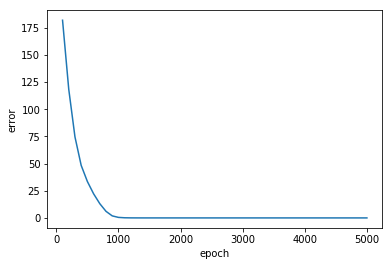

In [12]:
params_linear_r10=train(rand_data, 10, 5000, learning_rate=0.4, batch_size=100)

Internal activation: tanh
Learning rate: 0.4
batch size: 100
internal #epochs: 5000
reinit optimizer. New learning rate: 0.2
reinit optimizer. New learning rate: 0.1
reinit optimizer. New learning rate: 0.05


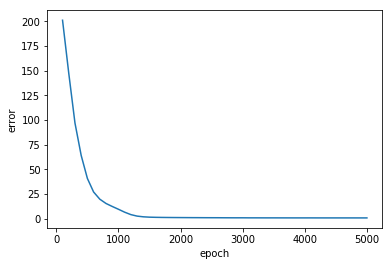

In [22]:
params_sigmoid_r10=train(rand_data, 10, 5000, internal_act='tanh', learning_rate=0.4, batch_size=100)

## Run on real data

We compute the embedding on a graph with 81306 vertices and 1768149 vertices. To embed the graph into 10 dimensions, we start with the most densest columns and increase the number of columns to embed. When we increase the number of columns to embed, we use the parameters trained from the previous run (on the dataset with a smaller number of columns).

In [5]:
elg = nx.read_edgelist("/home/ubuntu/datasets/twitter_combined.txt", create_using=nx.DiGraph())
spm = nx.to_scipy_sparse_matrix(elg, dtype='f')

In [6]:
def get_densest_idx(spm, num):
    colsum = np.ravel(spm.sum(axis=0))
    max_cols = np.sort(np.ravel(colsum), axis=None)[len(colsum) - num]
    return max_cols, colsum >= max_cols

def get_densest(spm, num):
    max_cols, idx = get_densest_idx(spm, num)
    sp_data = spm[:,idx]
    return sp_data

def get_densest2(spm, num1, num2):
    colsum = np.ravel(spm.sum(axis=1))
    sorted_colsum = np.sort(np.ravel(colsum), axis=None)
    max_cols1 = sorted_colsum[len(colsum) - num1]
    max_cols2 = sorted_colsum[len(colsum) - (num2 + num1)]
    sp_data1 = spm[:,colsum >= max_cols1]
    sp_data2 = spm[:,np.logical_and(colsum >= max_cols2, colsum < max_cols1)]
    return sp_data1, sp_data2

There are 81306 edges.


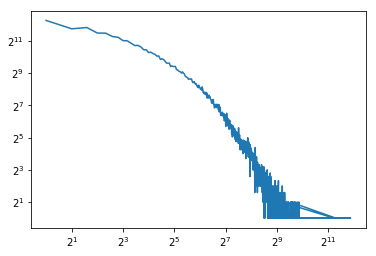

In [7]:
def deg_loglog(g):
    from collections import Counter
    nx_deg = nx.degree(g)
    deg = []
    for n, d in nx_deg:
        deg.append(d)
    cnt = Counter(deg)
    print('There are ' + str(sum(cnt.values())) + ' edges.')
    plt.loglog(cnt.keys(), cnt.values(), basex=2, basey=2)
    plt.show()
    
deg_loglog(elg)

### Curriculum learning

With curriculum learning, we can take advantage of the computation results from the denser columns.
To some extent, curriculum learning provides a new way of initializing the parameters of a neural network. We take the parameters from the neural network trained for the denser columns of a graph to initialize the neural network for the dataset with more columns.

The functions below expand and shrink the weight matrices for the smaller or the larger neural networks.

In [8]:
def init_params_svd(data, num_hidden):
    num_inputs = data.shape[1]
    U, s, Vh = sp.sparse.linalg.svds(data, k=num_hidden)
    
    new_params = {}
    new_params.update({weight_names[0]: mx.ndarray.array(Vh)})
    new_params.update({bias_names[0]: mx.ndarray.random_uniform(shape=(num_hidden,))})
    new_params.update({weight_names[1]: mx.ndarray.array(Vh.T)})
    new_params.update({bias_names[1]: mx.ndarray.random_uniform(shape=(num_inputs,))})
    return new_params

# Extend the weight matrices in the encoder of the smaller autoencoder to
# the shape required by the larger autoencoder.
def extend_params_encode(weight, bias, idx, num_inputs, num_outputs, init):
    if (isinstance(init, np.ndarray)):
        out_weight = init
    else:
        # We initialize the weights in the same way as MXNet
        out_weight = np.random.uniform(low=-0.1, high=0.1, size=(num_outputs, num_inputs))
    out_bias = np.zeros(num_outputs)
    out_weight[0:weight.shape[0], idx] = weight.asnumpy()
    out_bias[0:bias.shape[0]] = bias.asnumpy()
    return mx.nd.array(out_weight), mx.nd.array(out_bias)

# Extend the weight matrices in the decoder of the smaller autoencoder to
# the shape required by the larger autoencoder.
def extend_params_decode(weight, bias, idx, num_inputs, num_outputs, init):
    if (isinstance(init, np.ndarray)):
        out_weight = init
    else:
        # We initialize the weights in the same way as MXNet
        out_weight = np.random.uniform(low=-0.1, high=0.1, size=(num_outputs, num_inputs))
    out_bias = np.zeros(num_outputs)
    out_weight[idx, 0:weight.shape[1]] = weight.asnumpy()
    out_bias[idx] = bias.asnumpy()
    return mx.nd.array(out_weight), mx.nd.array(out_bias)

# Shrink the weight matrices in the encoder of the larger autoencoder to
# the shape required by the smaller autoencoder. This operation is
# the reverse of extend_params_encode.
def shrink_params_encode(weight, bias, idx, num_inputs, num_outputs):
    weight = weight.asnumpy()
    bias = bias.asnumpy()
    return mx.nd.array(weight[0:num_outputs, idx]), mx.nd.array(bias[0:num_outputs])

# Shrink the weight matrices in the decoder of the larger autoencoder to
# the shape required by the smaller autoencoder. This operation is
# the reverse of extend_params_decode.
def shrink_params_decode(weight, bias, idx, num_inputs, num_outputs):
    weight = weight.asnumpy()
    bias = bias.asnumpy()
    return mx.nd.array(weight[idx, 0:num_inputs]), mx.nd.array(bias[idx])

# This function extends the parameter matrices in the small autoencoder
# to an autoencoder with the specified number of input nodes and hidden nodes.
def extend_params(params, new_data, new_hidden, rand_init=False):
    old_inputs = params.get(weight_names[0]).shape[1]
    old_hidden = params.get(bias_names[0]).shape[0]
    new_inputs = new_data.shape[1]
    max_cols, max_idx = get_densest_idx(new_data, old_inputs)
    
    
    num_inputs = new_data.shape[1]
    U, s, Vh = sp.sparse.linalg.svds(new_data, k=new_hidden)
    if (rand_init):
        init = True
    else:
        init = Vh
    weight, bias = extend_params_encode(params.get(weight_names[0]),
                                        params.get(bias_names[0]), max_idx,
                                        new_inputs, new_hidden, init)
    new_params = {}
    new_params.update({weight_names[0]: weight})
    new_params.update({bias_names[0]: bias})
    if (rand_init):
        init = True
    else:
        init = Vh.T
    weight, bias = extend_params_decode(params.get(weight_names[1]),
                                        params.get(bias_names[1]), max_idx,
                                        new_hidden, new_inputs, init)
    new_params.update({weight_names[1]: weight})
    new_params.update({bias_names[1]: bias})
    return new_params

### Compute the embedding on the densest 10 columns.

In [15]:
sp_data10 = get_densest(spm, 10)
data10 = mx.ndarray.sparse.csr_matrix(sp_data10)
print(mx.ndarray.sum(data10, axis=0))
print(data10.shape)


[ 2490.  3383.  2484.  2758.  2476.  1789.  2133.  3011.  3239.  2155.]
<NDArray 10 @cpu(0)>
(81306L, 10L)


In [16]:
np_data10 = data10.asnumpy()
U, s, Vh = sp.linalg.svd(np_data10, full_matrices=False)
low_dim_data = np.dot(np_data10, Vh.T)
print(low_dim_data.shape)
print(np.max(low_dim_data))
print(np.min(low_dim_data))
res = np.dot(low_dim_data, Vh)
print("svd error: " + str(np.sum(np.square(res - np_data10))))

(81306, 10)
1.21314
-2.3992
svd error: 6.78263e-09


Learning rate: 0.1
batch size: 2000
internal #epochs: 2000


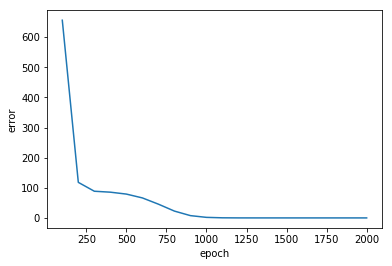

In [27]:
params_linear10=train(data10, 10, 2000, internal_act=None, learning_rate=0.1, batch_size=2000)

In [ ]:
params_linear10=train(data10, 10, 2000, internal_act=None, learning_rate=0.1, batch_size=2000)

Learning rate: 0.1
batch size: 2000
internal #epochs: 2000


Internal activation: tanh
Learning rate: 0.1
batch size: 2000
internal #epochs: 10000


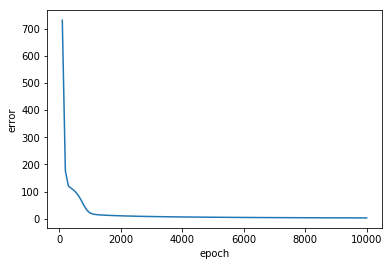

In [28]:
params_sigmoid10=train(data10, 10, 10000, internal_act='tanh', learning_rate=0.1, batch_size=2000)

Internal activation: tanh
Output activation: sigmoid
Learning rate: 0.2
batch size: 2000
internal #epochs: 10000


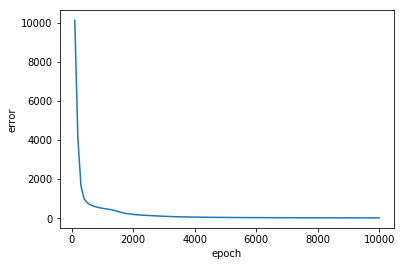

In [29]:
params_sigmoid10=train(data10, 10, 10000, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)

### Train an autoencoder with curriculum learning

In [11]:
def train_cl(target_ndims, target_red_ndims, num_epoc, init_ndims=40,
              init_red_ndims=20, num_incs = 10,
              iact='relu', learning_rate=0.8):
    ndims = init_ndims
    red_ndims = init_red_ndims
    ndims_inc_exp = math.pow((float(target_ndims)/init_ndims), 1/float(num_incs))
    red_ndims_inc = (float(target_red_ndims) - init_red_ndims) / num_incs
    print("#dims increase by a factor of " + str(ndims_inc_exp))
    print("#red dims increase by " + str(red_ndims_inc))
    
    print("#dims: " + str(ndims))
    print("reduce #dims to " + str(red_ndims))
    sp_data = get_densest(spm, ndims)
    U, s, Vh = sp.sparse.linalg.svds(sp_data, k=red_ndims)
    res = np.dot(sp_data.dot(Vh.T), Vh)
    print("svd error: " + str(np.sum(np.square(res - sp_data))))

    data = mx.ndarray.sparse.csr_matrix(sp_data)
    model = AutoEncoderModel(data, num_dims=red_ndims, internal_act=iact, learning_rate=learning_rate, batch_size=2000)
    params, _, errors = model.train(data, num_epoc=num_epoc, return_err=True, int_epoc=5)
    params_seq = [params]
    errors_seq = [errors]

    for i in range(num_incs):
        ndims = int(ndims * ndims_inc_exp)
        red_ndims = int(red_ndims + red_ndims_inc)
        print("#dims: " + str(ndims))
        print("reduce #dims to " + str(red_ndims))
        sp_data = get_densest(spm, ndims)
        U, s, Vh = sp.sparse.linalg.svds(sp_data, k=red_ndims)
        res = np.dot(sp_data.dot(Vh.T), Vh)
        print("svd error: " + str(np.sum(np.square(res - sp_data))))
        print("")

        data = mx.ndarray.sparse.csr_matrix(sp_data)
        print("Train from previous results")
        params_init = extend_params(params, sp_data, red_ndims, rand_init=True)
        model = AutoEncoderModel(data, num_dims=red_ndims, internal_act=iact, learning_rate=learning_rate, batch_size=2000)
        params, _, errors = model.train(data, num_epoc=num_epoc, return_err=True, params=params_init, int_epoc=5)
        params_seq.append(params)
        errors_seq.append(errors)
        #print("Train from scratch")
        #model = AutoEncoderModel(data, num_dims=red_ndims, internal_act=iact, learning_rate=learning_rate, batch_size=2000)
        #model.train(data, num_epoc=num_epoc, int_epoc=5)

#dims increase by a factor of 1.14163099142
#red dims increase by 2.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
It takes 11.8589699268 seconds
The error: 14961.1


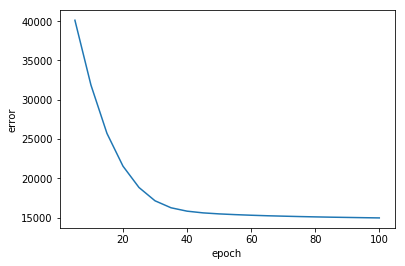

#dims: 45
reduce #dims to 22
svd error: 15658.7

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 12.4799489975 seconds
The error: 15957.4


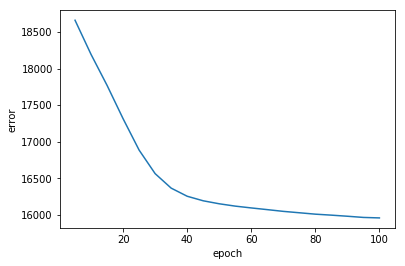

#dims: 51
reduce #dims to 24
svd error: 17505.4

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 14.5262870789 seconds
The error: 17861.6


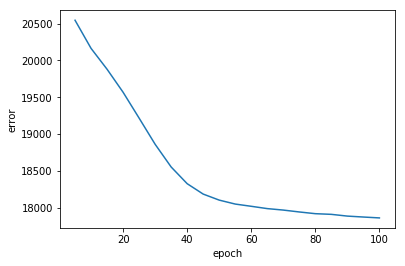

#dims: 58
reduce #dims to 26
svd error: 19876.2

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 15.9073200226 seconds
The error: 20191.6


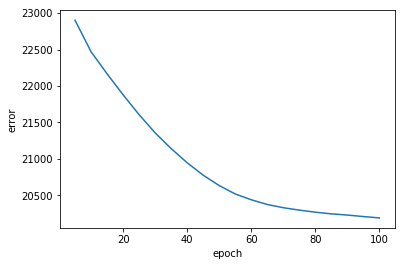

#dims: 66
reduce #dims to 28
svd error: 23086.2

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 16.6538589001 seconds
The error: 23413.5


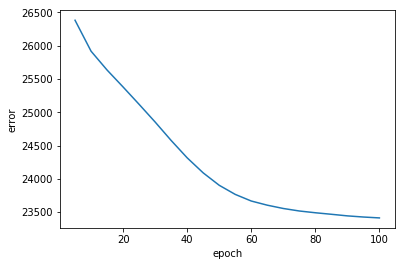

#dims: 75
reduce #dims to 30
svd error: 25858.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 18.4974498749 seconds
The error: 26497.6


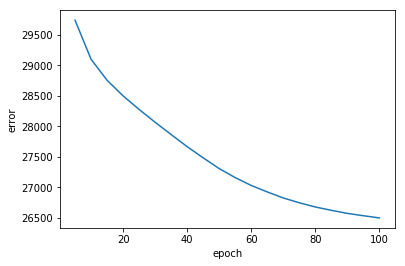

#dims: 85
reduce #dims to 32
svd error: 29855.3

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 20.7074751854 seconds
The error: 30616.9


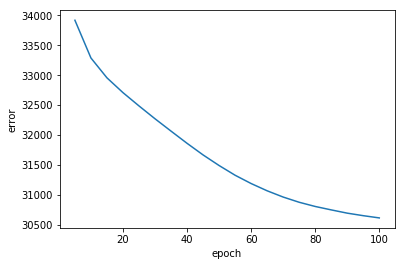

#dims: 97
reduce #dims to 34
svd error: 33382.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 23.705946207 seconds
The error: 34859.2


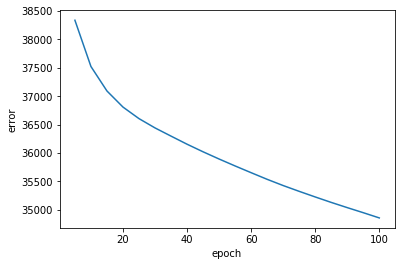

#dims: 110
reduce #dims to 36
svd error: 37653.6

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 27.8602831364 seconds
The error: 39046.0


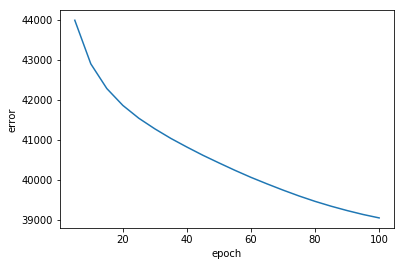

#dims: 125
reduce #dims to 38
svd error: 42048.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 29.7603461742 seconds
The error: 43819.1


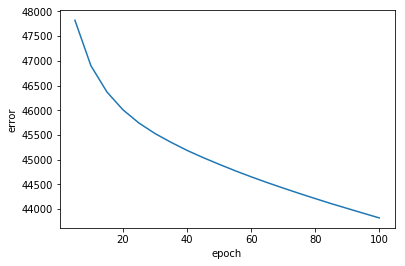

#dims: 142
reduce #dims to 40
svd error: 47232.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 31.5695800781 seconds
The error: 49382.7


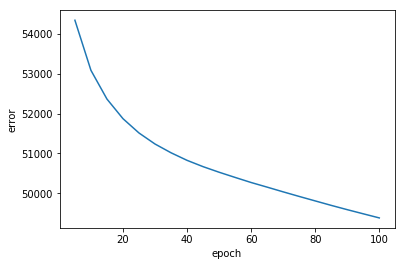

#dims: 162
reduce #dims to 42
svd error: 52506.3

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 36.6647748947 seconds
The error: 55249.3


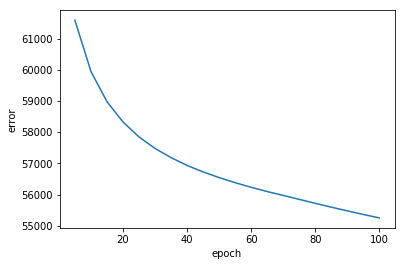

#dims: 184
reduce #dims to 44
svd error: 57972.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 42.018682003 seconds
The error: 61473.1


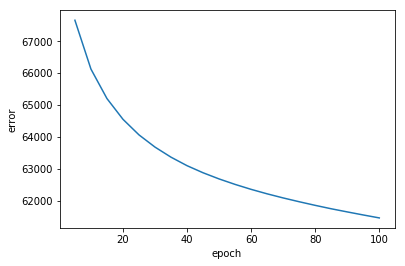

#dims: 210
reduce #dims to 46
svd error: 64194.6

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 48.2823889256 seconds
The error: 68553.3


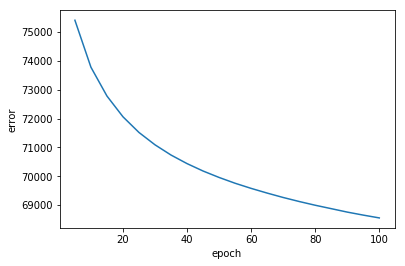

#dims: 239
reduce #dims to 48
svd error: 71096.4

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 53.825327158 seconds
The error: 76816.6


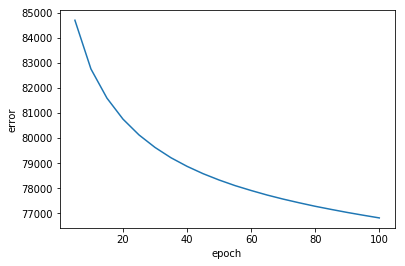

#dims: 272
reduce #dims to 50
svd error: 78701.9

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 60.3585259914 seconds
The error: 85871.9


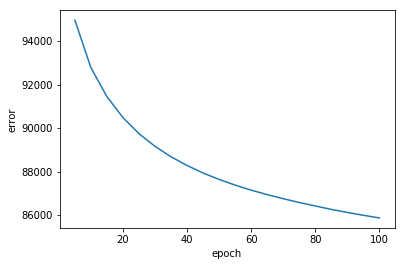

#dims: 310
reduce #dims to 52
svd error: 85999.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 67.4936561584 seconds
The error: 94682.8


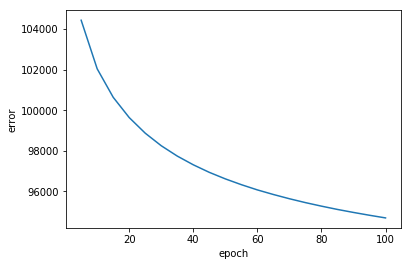

#dims: 353
reduce #dims to 54
svd error: 94736.9

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 77.0985181332 seconds
The error: 105659.0


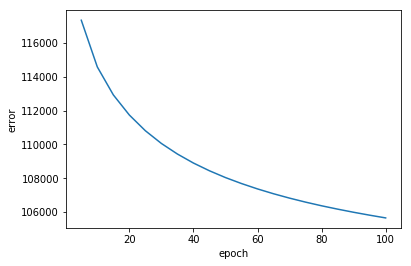

#dims: 402
reduce #dims to 56
svd error: 104708.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 85.6059479713 seconds
The error: 118134.0


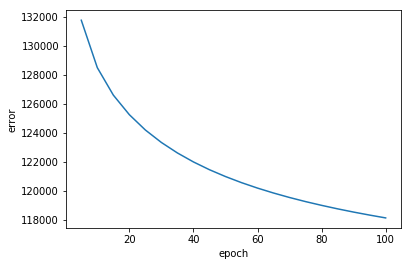

#dims: 458
reduce #dims to 58
svd error: 114799.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 96.0793209076 seconds
The error: 130803.0


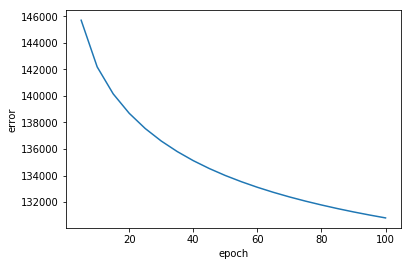

#dims: 522
reduce #dims to 60
svd error: 125318.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 112.578986168 seconds
The error: 144523.0


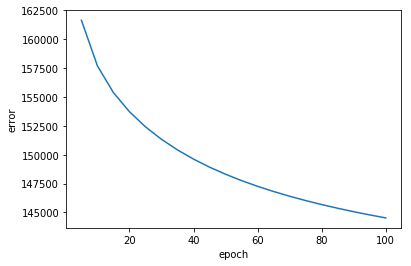

#dims: 595
reduce #dims to 62
svd error: 138381.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 125.514950037 seconds
The error: 162314.0


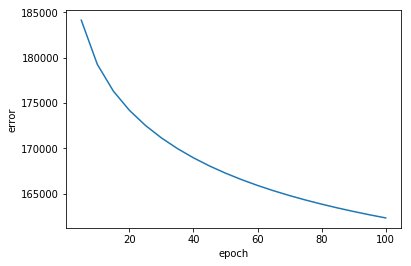

#dims: 679
reduce #dims to 64
svd error: 151308.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 130.553845882 seconds
The error: 180030.0


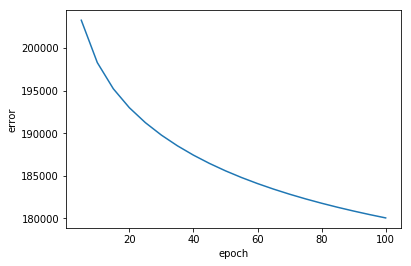

#dims: 775
reduce #dims to 66
svd error: 165031.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 156.391175985 seconds
The error: 198665.0


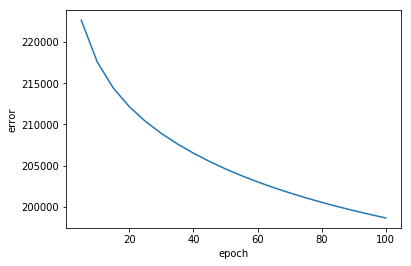

#dims: 884
reduce #dims to 68
svd error: 181194.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8
It takes 183.25889802 seconds
The error: 222917.0


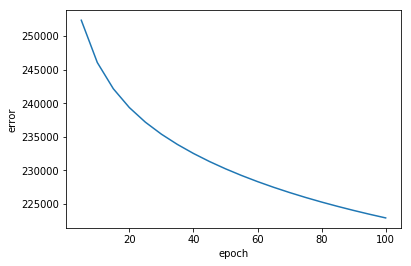

#dims: 1009
reduce #dims to 70
svd error: 196638.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 0.8
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 0.8


In [ ]:
train_cl(8000, 100, 100, num_incs=40)

In [ ]:
pref_matrix = [[0.9, 0.1], [0.1, 0.9]]
block_sizes = [70, 30]
g = ig.Graph.SBM(100, pref_matrix, block_sizes, directed=True)
sim_spm = g.get_adjacency()